## ELETTRA-03: ID linear optics distortion

In [1]:
# In this example effects of an ID (APPLE-II device represented by a linear 4x4 symplectic matrix) are presented
# ID is inserted replacing a selected marker and the drifts around it are adjuced

# The following effects on the linear optics are investigated

# -- Tune shifts
# -- Dispersion
# -- Beta beating
# -- Coupling (minimal tune distance)

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.linear import Linear

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Keep only markers at the center of long straight sections

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace sextupoles with quadrupoles

from model.library.element import Element
from model.library.quadrupole import Quadrupole

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def function(element:Element) -> None:
    element.linear = True

ring.apply(function, kinds=['Dipole'])

# Merge and rename drifts

ring.merge()

# Change start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Splice lattice

ring.roll(1)
ring.splice()

# Describe

ring.describe

{'BPM': 168, 'Drift': 708, 'Dipole': 156, 'Quadrupole': 360, 'Marker': 12}

In [6]:
# Compute tunes (fractional part)

guess = torch.tensor(4*[0.0], dtype=torch.float64)
nux, nuy = tune(ring, [], alignment=False, matched=True, guess=guess, limit=1, epsilon=1.0E-9)

In [7]:
# Compute dispersion

guess = torch.tensor(4*[0.0], dtype=dtype)
(etaqx, etapx, etaqy, etapy) = dispersion(ring, guess, [], alignment=False, advance=True, limit=1, epsilon=1.0E-9)

In [8]:
# Compute twiss

(ax, bx, ay, by) = twiss(ring, [], alignment=False, matched=True, advance=True, full=False, guess=guess, limit=1, epsilon=1.0E-9).T

In [9]:
# Compute advance

mux, muy =  advance(ring, [], alignment=False, matched=True, guess=guess, limit=1, epsilon=1.0E-9).T

In [10]:
# Compute coupling

coupling(ring, [])

tensor(0., dtype=torch.float64)

In [11]:
# Define ID from linear 4x4 matrix

vector = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype)

matrix = torch.tensor([[1.0546523413432733, 3.854440592808663, 0.0009255226506728176, 0.00018322996225628543], 
                       [0.028563471642583493, 1.052571438617416, 0.000028046397735354812, -0.0007805959814819128], 
                       [0.0007803059043888712, -0.0001750400689191113, 0.9280584935716627, 3.632863324850749], 
                       [-0.000029262758704731062, -0.0009258882227087091, -0.03883170772079424, 0.9255132588382271]], dtype=dtype)

ID = Linear('ID', vector.tolist(), matrix.tolist())
ID.length = 3.76

In [12]:
# Insert ID

ring.flatten()
ring.insert(ID, 'MLL_S01', position=0.0)
ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 708,
 'Dipole': 156,
 'Quadrupole': 360,
 'Linear': 1,
 'Marker': 11}

In [13]:
# Compute tunes (fractional part)

guess = torch.tensor(4*[0.0], dtype=torch.float64)
nux_id, nuy_id = tune(ring, [], alignment=False, matched=True, guess=guess, limit=8, epsilon=1.0E-9)

In [14]:
# Compute dispersion

guess = torch.tensor(4*[0.0], dtype=dtype)
(etaqx_id, etapx_id, etaqy_id, etapy_id) = dispersion(ring, guess, [], alignment=False, advance=True, limit=1, epsilon=1.0E-9)

In [15]:
# Compute twiss

(ax_id, bx_id, ay_id, by_id) = twiss(ring, [], alignment=False, matched=True, advance=True, full=False, guess=guess, limit=1, epsilon=1.0E-9).T

In [16]:
# Compute advance

mux_id, muy_id =  advance(ring, [], alignment=False, matched=True, guess=guess, limit=1, epsilon=1.0E-9).T

In [17]:
# Tune shifts

print(nux - nux_id)
print(nuy - nuy_id)

tensor(0.0211, dtype=torch.float64)
tensor(-0.0056, dtype=torch.float64)


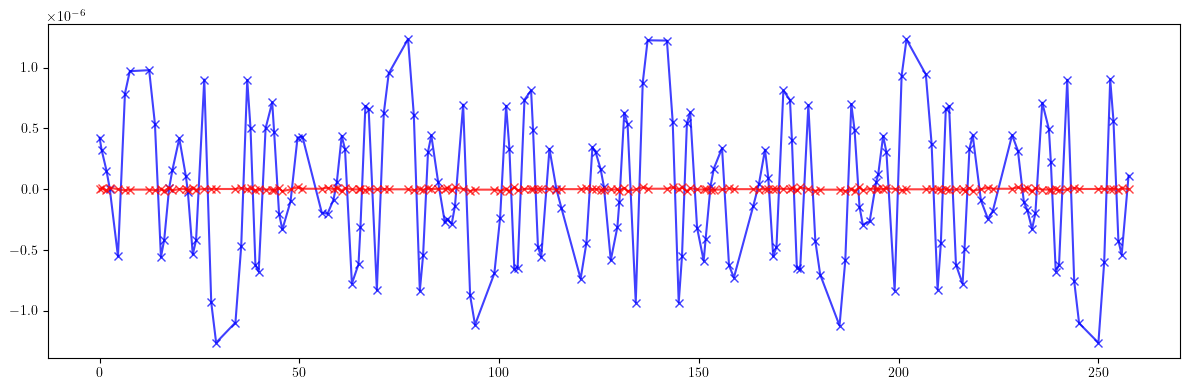

In [18]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

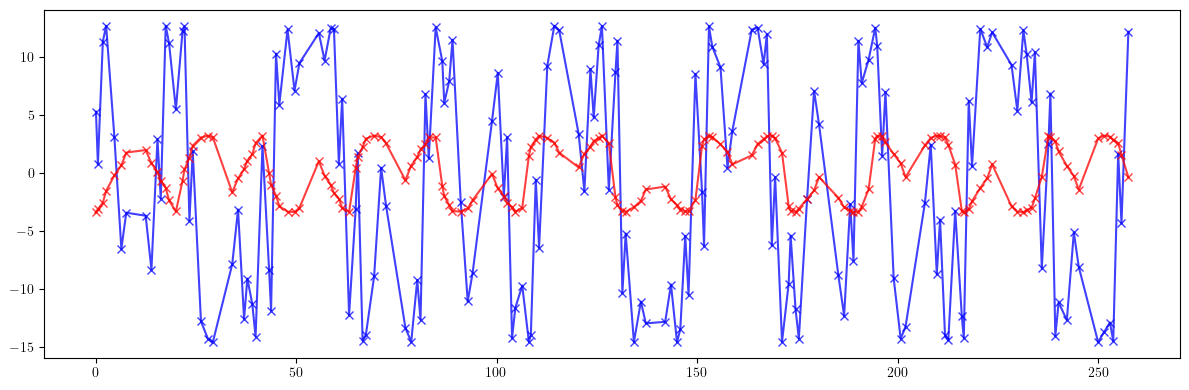

In [19]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

In [20]:
# Coupling

coupling(ring, [])

tensor(0.0002, dtype=torch.float64)